# Random Forest por clasificación

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# Modelado
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_percentage_error, root_mean_squared_error, r2_score
# Optimizar
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,validation_curve
# from tqdm import tqdm
import warnings
from utils import get_regression_metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from pickle import dump
from sklearn.tree import DecisionTreeRegressor
from utils import get_classifier_metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



In [99]:
df_ini = pd.read_csv('../data/processed/df_ini_insulina.csv')



## Split

In [100]:
# Dividimos el conjunto de datos en muestras de train y test
X = df_ini.drop('Outcome', axis=1)
y = df_ini['Outcome']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [101]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [102]:
model_forest_clas = RandomForestClassifier(random_state = 42)
model_forest_clas.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


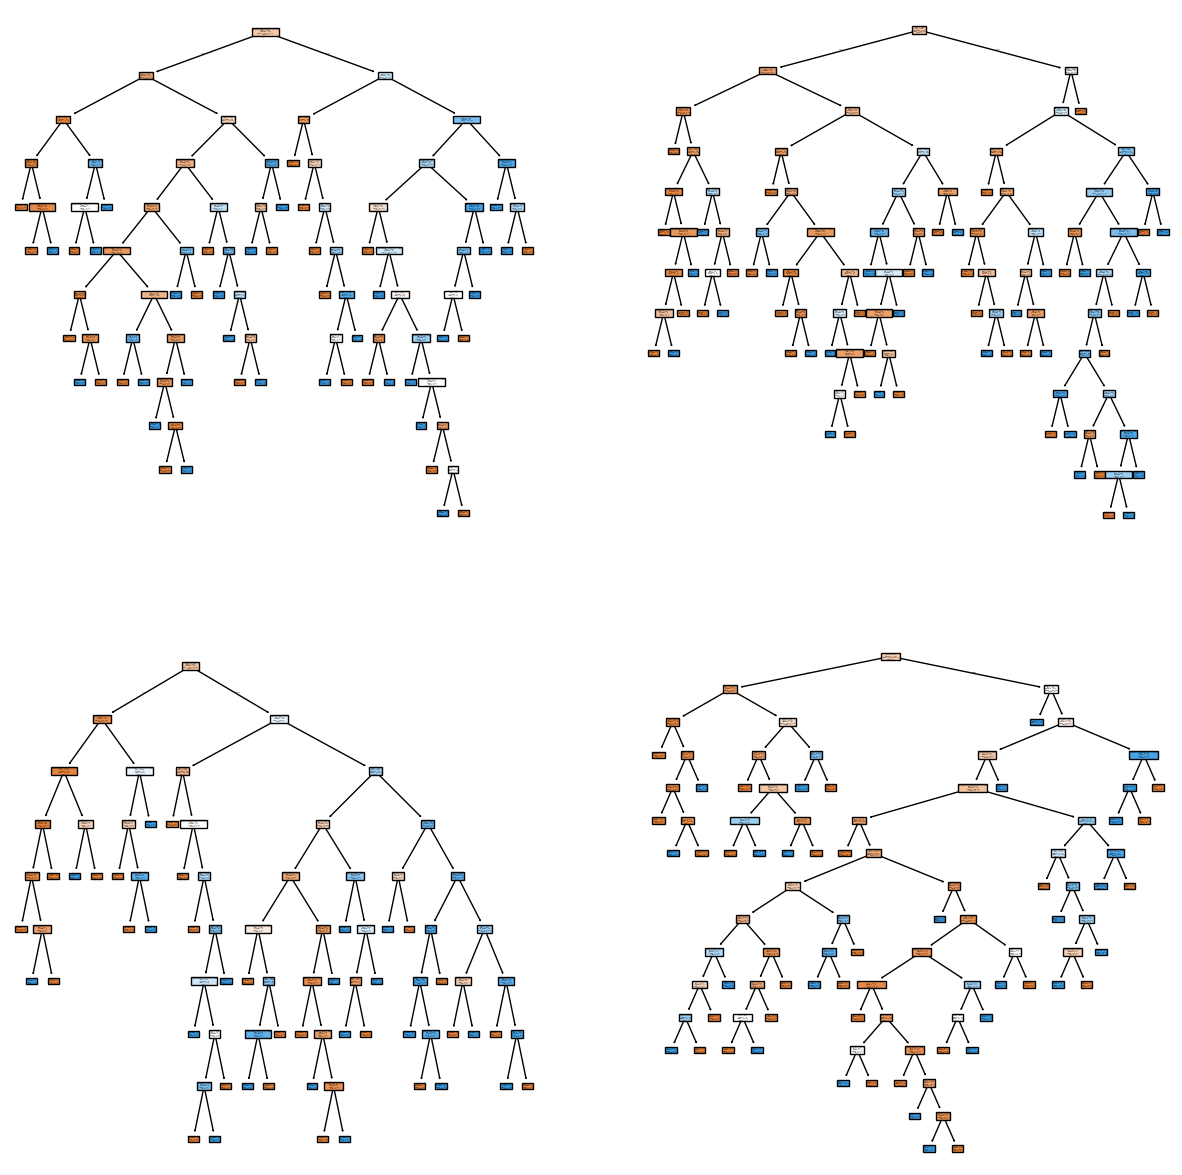

In [103]:
fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# We show the first 4 trees out of the 100 generated (default)
# En class_names porngo 0 o 1 ya que mi Outcome que es mi target es 0 o 1 segun si es positivo o negativo.

tree.plot_tree(model_forest_clas.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [104]:
y_pred_test = model_forest_clas.predict(X_test)
y_pred_train = model_forest_clas.predict(X_train)


In [105]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.810127,0.810127,0.810127,0.810127


In [106]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train, 'macro')

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.810127,0.787062,0.789913,0.784544


In [107]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train, average='weighted')

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.810127,0.809239,0.808629,0.810127


> ### 1º Conclusión:
> Nuestro modelo actualmente tiene un 77% de acierto, pero como tenemos un train del 100% tenemos un sobre entrenamiento por lo que vamos a hiperparametrizar para mejorar los resultados.

### Hiperparametrización

In [108]:
# Definir hiperparámetros a probar
hparam_foreclas = {'n_estimators': [50, 100, 200],
                   'max_depth': [3, 5, 10],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

# Implementar GridSearchCV
grid_search_foreclas = GridSearchCV(RandomForestClassifier(random_state=18),
                                hparam_foreclas,
                                cv=5,
                                n_jobs=-1,
                                verbose=1)

# Entrenamos
grid_search_foreclas.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
grid_search_foreclas.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

### Best Estimator

In [109]:
# Mejor modelo
grid_search_foreclas.best_estimator_

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [110]:
# Entrenamos
grid_search_foreclas.best_estimator_.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [111]:
y_pred_test_grid = grid_search_foreclas.best_estimator_.predict(X_test)
y_pred_train_grid = grid_search_foreclas.best_estimator_.predict(X_train)

In [112]:
#Random Forest - métricas.
get_classifier_metrics(y_pred_test_grid, y_test, y_pred_train_grid, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,0.910543,0.910543,0.910543,0.910543
Test set,0.822785,0.822785,0.822785,0.822785


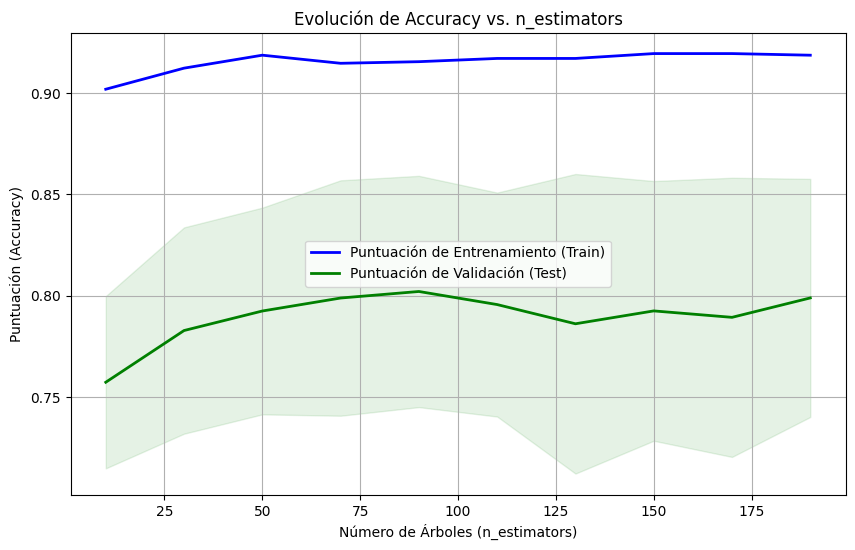

In [113]:
# Defino los valores de n_estimators a probar (de 10 a 200) ya que el mejor dado por la hiper parametrización es el 100.
n_estimators_range = np.arange(10, 201, 20) 

# Calculo la curva de validación, fijando los MEJORES HIPERPARÁMETROS antes realizados.
train_scores, test_scores = validation_curve(RandomForestClassifier(random_state=18,
                                                                    criterion='gini',
                                                                    max_depth=5,
                                                                    min_samples_leaf=1,
                                                                    min_samples_split=2),
                                                                    X_train, y_train, 
                                                                    param_name="n_estimators", 
                                                                    param_range=n_estimators_range, 
                                                                    cv=5, 
                                                                    scoring="accuracy",
                                                                    n_jobs=-1)

# 3. Calculo la media y desviación estándar de los scores.
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. Grafico la evolución.
plt.figure(figsize=(10, 6))
plt.title("Evolución de Accuracy vs. n_estimators")
plt.xlabel("Número de Árboles (n_estimators)")
plt.ylabel("Puntuación (Accuracy)")
plt.grid(True)

# Curva de entrenamiento.
plt.plot(n_estimators_range, train_scores_mean, 
         label="Puntuación de Entrenamiento (Train)", color="blue", lw=2)

# Curva de validación (test).
plt.plot(n_estimators_range, test_scores_mean, 
         label="Puntuación de Validación (Test)", color="green", lw=2)

# Relleno el área de desviación estándar.
plt.fill_between(n_estimators_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.show()

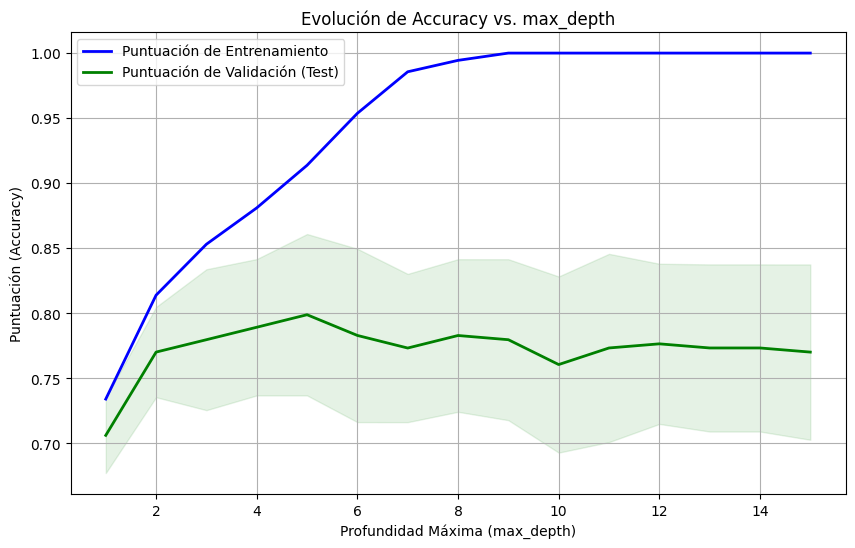

In [114]:
# 1. Defino los valores de max_depth a probar (eje X).
# Se prueba desde 1 hasta 15 de profundidad ya que el mejor dato dato en la hiperparametrización es el 5.
max_depth_range = np.arange(1, 16) 

# 2. Calculo la curva de validación.
# Uso un n_estimators fijo, el 100 que es el que sale en el mejor hiper parametro.
train_scores, test_scores = validation_curve(RandomForestClassifier(random_state=18,
                                                                    n_estimators=100,
                                                                    criterion='gini',
                                                                    max_depth=5,
                                                                    min_samples_leaf=1,
                                                                    min_samples_split=2),
                                                                    X_train, y_train, 
                                                                    param_name="max_depth", 
                                                                    param_range=max_depth_range,
                                                                    cv=5, 
                                                                    scoring="accuracy",
                                                                    n_jobs=-1)

# 3. Calcular la media de los scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# 4. Graficar la evolución
plt.figure(figsize=(10, 6))
plt.title("Evolución de Accuracy vs. max_depth")
plt.xlabel("Profundidad Máxima (max_depth)")
plt.ylabel("Puntuación (Accuracy)")
plt.grid(True)

plt.plot(max_depth_range, train_scores_mean, 
         label="Puntuación de Entrenamiento", color="blue", lw=2)

plt.plot(max_depth_range, test_scores_mean, 
         label="Puntuación de Validación (Test)", color="green", lw=2)

plt.fill_between(max_depth_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.show()

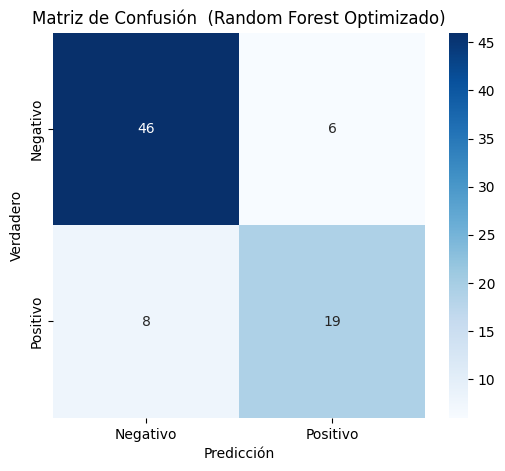

In [115]:
# Obtener el mejor modelo
best_model_insu = grid_search_foreclas.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best_insu = best_model_insu.predict(X_test)

# Matriz de confusión
conf_matrix_insu = confusion_matrix(y_test,
                                    y_pred_best_insu)


# Visualización
class_names = ["Negativo", "Positivo"]
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_insu,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión  (Random Forest Optimizado)")
plt.show()

In [116]:
with open('../models/random_forest_clas_insulina.pkl', 'wb') as file:
    pickle.dump(best_model_insu, file)

> ### Conslusión:
>
> - Con la hiperparametrizacion he conseguido bajar el train de 100 a 91 con un test de 82%.
> - De 54 casos analizados como negativo, 46 fueron negativos realmente y 8 positivos. Por lo que hay un 85.19% de acierto y un 14.81% de error.
> - De 25 casos positivos analizados, 19 fueron realmente positivos y 6 negativos. Por lo que hay un 76% de acierto y un 24% de error.